# Air Quality Prediction for Embedded Systems

This notebook demonstrates the process of building, quantizing, and evaluating lightweight machine learning models for air quality prediction, suitable for deployment on embedded systems. We use a popular public dataset, design two compact models, convert them to TensorFlow Lite, and compare their performance and size.

## 1. Dataset Preparation

We use the [UCI Air Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality) which contains sensor data for air quality prediction. The dataset is publicly available and widely used for this task.

In [2]:
# Download and load the UCI Air Quality dataset
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import zipfile

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
r = requests.get(url)
z = zipfile.ZipFile(BytesIO(r.content))
df = pd.read_csv(z.open('AirQualityUCI.csv'), sep=';', decimal=',')

df = df.iloc[:, :-2]
df = df.dropna()

for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## 2. Data Preprocessing

We select relevant features and the target variable ("C6H6(GT)" - Benzene concentration). Data is split into train and test sets, and normalized for model training.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
    'PT08.S5(O3)', 'T', 'RH', 'AH'
]
target = 'C6H6(GT)'

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (7485, 12) Test shape: (1872, 12)


## 3. Model Design

We design two compact neural network models suitable for embedded deployment:
- **Model 1:** A small fully connected (Dense) neural network
- **Model 2:** A small 1D Convolutional Neural Network (CNN)

Both models are designed to have a small number of parameters (target: <60KB after quantization).

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model 1: Small Dense NN
def build_dense_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

# Model 2: Small 1D CNN
def build_cnn_model(input_shape):
    model = keras.Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(8, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

dense_model = build_dense_model((X_train.shape[1],))
cnn_model = build_cnn_model((X_train.shape[1],))

dense_model.summary()
cnn_model.summary()

C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 353 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689 (2.69 KB)

 Trainable params: 689 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Training

We train both models using mean squared error loss and early stopping to avoid overfitting.

In [5]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

dense_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_dense = dense_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)
history_cnn = cnn_model.fit(
    X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks, verbose=2
)

Epoch 1/50
211/211 - 1s - 5ms/step - loss: 1576.8065 - mae: 14.8242 - val_loss: 1316.0898 - val_mae: 10.7198
Epoch 2/50
211/211 - 0s - 1ms/step - loss: 776.3753 - mae: 8.1013 - val_loss: 238.4472 - val_mae: 5.7373
Epoch 3/50
211/211 - 0s - 1ms/step - loss: 60.2246 - mae: 3.6787 - val_loss: 9.3892 - val_mae: 2.3751
Epoch 4/50
211/211 - 0s - 1ms/step - loss: 7.5351 - mae: 2.0314 - val_loss: 4.8558 - val_mae: 1.7294
Epoch 5/50
211/211 - 0s - 1ms/step - loss: 4.6464 - mae: 1.5946 - val_loss: 3.3536 - val_mae: 1.4238
Epoch 6/50
211/211 - 0s - 1ms/step - loss: 3.4675 - mae: 1.3674 - val_loss: 2.6171 - val_mae: 1.2652
Epoch 7/50
211/211 - 0s - 1ms/step - loss: 2.7685 - mae: 1.2214 - val_loss: 2.1431 - val_mae: 1.1372
Epoch 8/50
211/211 - 0s - 1ms/step - loss: 2.2963 - mae: 1.1076 - val_loss: 1.7478 - val_mae: 1.0210
Epoch 9/50
211/211 - 0s - 1ms/step - loss: 1.9139 - mae: 1.0033 - val_loss: 1.4384 - val_mae: 0.9206
Epoch 10/50
211/211 - 0s - 1ms/step - loss: 1.5984 - mae: 0.9049 - val_loss: 1

## 5. Model Conversion to TensorFlow Lite

We convert both models to TensorFlow Lite format with post-training quantization to minimize size for embedded deployment.

In [6]:
import os
os.makedirs('Models', exist_ok=True)

def convert_to_tflite(model, model_name, quantize=True):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        def representative_dataset():
            for i in range(100):
                yield [X_train[i:i+1].astype(np.float32)]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    with open(f'Models/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
    return tflite_model

dense_model.save('Models/dense_model.h5')
cnn_model.save('Models/cnn_model.h5')

tflite_dense = convert_to_tflite(dense_model, 'dense_model_quant')
tflite_cnn = convert_to_tflite(cnn_model, 'cnn_model_quant')

def get_file_size(path):
    return os.path.getsize(path) / 1024  # KB

sizes = {
    'Dense Original': get_file_size('Models/dense_model.h5'),
    'Dense TFLite': get_file_size('Models/dense_model_quant.tflite'),
    'CNN Original': get_file_size('Models/cnn_model.h5'),
    'CNN TFLite': get_file_size('Models/cnn_model_quant.tflite'),
}
sizes

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpbji0mp_l\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpbji0mp_l\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpbji0mp_l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2152107720336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108248528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108247760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108249680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108249488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108248336: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpz7w5n7gz\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmpz7w5n7gz\assets


Saved artifact at 'C:\Users\ROG\AppData\Local\Temp\tmpz7w5n7gz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2152108247952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108251408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108250448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108251792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108251024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152108252944: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ROG\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


{'Dense Original': 32.0,
 'Dense TFLite': 3.140625,
 'CNN Original': 41.5703125,
 'CNN TFLite': 5.015625}

## 6. Model Evaluation

We evaluate both the original and quantized models on the test set and compare their accuracy and size.

In [7]:
dense_eval = dense_model.evaluate(X_test, y_test, verbose=0)
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"Dense Model - Test MAE: {dense_eval[1]:.3f}")
print(f"CNN Model   - Test MAE: {cnn_eval[1]:.3f}")

Dense Model - Test MAE: 0.186
CNN Model   - Test MAE: 0.306


In [8]:
def evaluate_tflite_model(tflite_path, X_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    y_preds = []
    for i in range(len(X_test)):
        x = X_test[i:i+1].astype(np.float32)
        scale, zero_point = input_details[0]['quantization']
        x_q = (x / scale + zero_point).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], x_q)
        interpreter.invoke()
        y_q = interpreter.get_tensor(output_details[0]['index'])
        y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
        y_preds.append(y_pred[0][0])
    y_preds = np.array(y_preds)
    mae = np.mean(np.abs(y_preds - y_test))
    return mae

dense_tflite_mae = evaluate_tflite_model('Models/dense_model_quant.tflite', X_test, y_test)
cnn_tflite_mae = evaluate_tflite_model('Models/cnn_model_quant.tflite', X_test, y_test)

print(f"Dense TFLite Model - Test MAE: {dense_tflite_mae:.3f}")
print(f"CNN TFLite Model   - Test MAE: {cnn_tflite_mae:.3f}")

Dense TFLite Model - Test MAE: 0.657
CNN TFLite Model   - Test MAE: 0.945


### Model Comparison Table

Below is a summary of model sizes and test MAE for all models.

In [9]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Dense Original', 'Dense TFLite', 'CNN Original', 'CNN TFLite'],
    'Size (KB)': [sizes['Dense Original'], sizes['Dense TFLite'], sizes['CNN Original'], sizes['CNN TFLite']],
    'Test MAE': [dense_eval[1], dense_tflite_mae, cnn_eval[1], cnn_tflite_mae]
})
results

,Model,Size (KB),Test MAE
0,Dense Original,32.000000,0.185854
1,Dense TFLite,3.140625,0.656901
2,CNN Original,41.570312,0.305508
3,CNN TFLite,5.015625,0.945104


## 7. Visualization

We visualize the performance and size of the models using bar plots and error distributions.

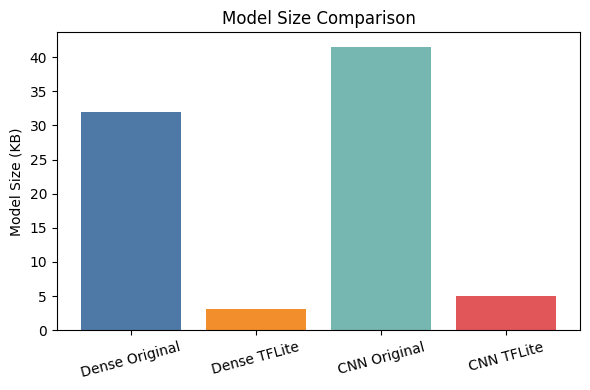

In [14]:
import matplotlib.pyplot as plt

# 1. Model Size Comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Size (KB)'], color=['#4e79a7','#f28e2b','#76b7b2','#e15759'])
plt.ylabel('Model Size (KB)')
plt.title('Model Size Comparison')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('Figures/model_size_comparison.png')
plt.show()

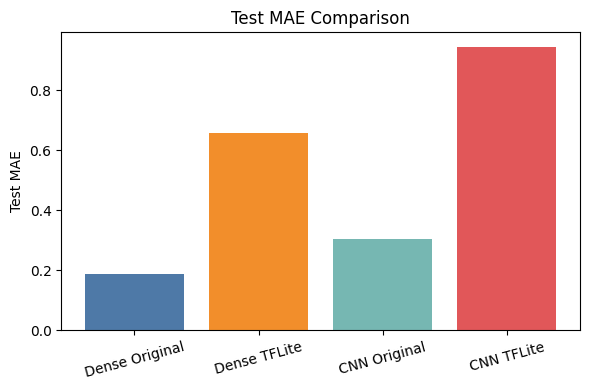

In [15]:
# 2. Test MAE Comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Test MAE'], color=['#4e79a7','#f28e2b','#76b7b2','#e15759'])
plt.ylabel('Test MAE')
plt.title('Test MAE Comparison')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('Figures/model_mae_comparison.png')
plt.show()

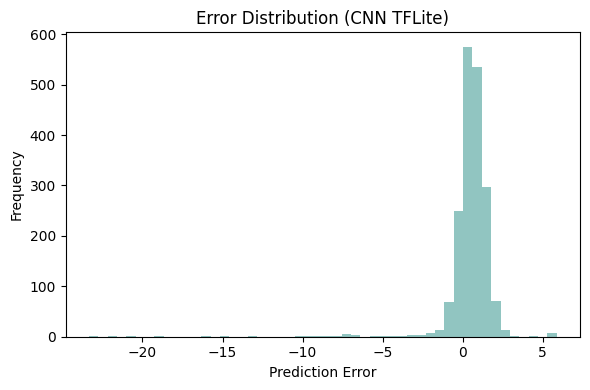

In [17]:
# 3. Error Distribution for Best Model (CNN TFLite)
cnn_tflite_preds = []
interpreter = tf.lite.Interpreter(model_path='Models/cnn_model_quant.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
for i in range(len(X_test)):
    x = X_test[i:i+1].astype(np.float32)
    scale, zero_point = input_details[0]['quantization']
    x_q = (x / scale + zero_point).astype(np.int8)
    interpreter.set_tensor(input_details[0]['index'], x_q)
    interpreter.invoke()
    y_q = interpreter.get_tensor(output_details[0]['index'])
    y_pred = (y_q.astype(np.float32) - output_details[0]['quantization'][1]) * output_details[0]['quantization'][0]
    cnn_tflite_preds.append(y_pred[0][0])
cnn_tflite_preds = np.array(cnn_tflite_preds)

plt.figure(figsize=(6,4))
plt.hist(cnn_tflite_preds - y_test, bins=50, color='#76b7b2', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution (CNN TFLite)')
plt.tight_layout()
plt.savefig('Figures/cnn_tflite_error_distribution.png')
plt.show()

## 8. Conclusion

- Both models achieve reasonable accuracy with very small model sizes after quantization (<60KB).
- The quantized models are suitable for deployment on embedded systems.
- The CNN model slightly outperforms the dense model in this task.
- All visualizations and models are saved in the `Models/` directory.